## Climate indicator comparisons

In [2]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

OUTPATH = './output'
IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [3]:
obs = pd.read_csv(IOPATH)
obs

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),...,Zn (nmol kg-1),source,Nstar (umol kg-1),spice,density (kg m-3),current,location,[TA-DIC] (uM),NSdist,EWdist
0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378648,1378648,1402109,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,312.025459,...,NaN,ooi,NaN,-0.251376,1024.310436,NaN,slope,NaN,484.541716,NaN
1378649,1378649,1402110,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,NaN,...,NaN,ooi,NaN,-0.251582,1024.310612,NaN,slope,NaN,484.541716,NaN
1378650,1378650,1402111,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,202.661375,...,NaN,ooi,NaN,-0.405998,1024.962794,shelf,shelf,NaN,215.824564,-0.0
1378651,1378651,1402112,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,308.384776,...,NaN,ooi,NaN,-0.452611,1024.296731,shelf,shelf,NaN,215.824564,-0.0


In [4]:
pd.unique(obs['current'])

array(['shelf', nan, 'CC', 'CUC'], dtype=object)

In [ ]:
# add year and month column
obs['time'] = pd.to_datetime(obs['time'])

obs['year'] = obs.time.dt.year
obs['months'] = obs.time.dt.month

In [12]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

### Where I got climate indicators from:

Originally from my research with Rich which can be found in /ocean/ghoeven/Atlas/Climatology2024

enso.csv 
https://psl.noaa.gov/enso/mei/

npgo.csv 
http://www.o3d.org/npgo/

pdo.csv
https://www.ncei.noaa.gov/access/monitoring/pdo/

In [5]:
# Loading in Climate Indicators

# ENSO
enso = pd.read_csv('/ocean/ghoeven/MOAD/Data/enso1979.csv', names=['year']+[str(x+1) for x in range(12)])

enso = enso.melt(id_vars='year', var_name='month', value_name='index')
enso['month'] = enso['month'].astype(int)
enso = enso.sort_values(['year', 'month']).reset_index(drop=True)

enso['day'] = 1 
enso['time'] = pd.to_datetime(enso[['year', 'month', 'day']])

start_of_year = pd.to_datetime(enso['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((enso['year'] + 1).astype(str) + "-01-01")
enso['decimal_yr'] = enso['year'] + (
    (enso['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# NPGO
npgo = pd.read_csv('/ocean/ghoeven/MOAD/Data/npgo1950.csv', names=['year', 'month', 'index'])

npgo['day'] = 1 
npgo['time'] = pd.to_datetime(npgo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(npgo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((npgo['year'] + 1).astype(str) + "-01-01")
npgo['decimal_yr'] = npgo['year'] + (
    (npgo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# PDO
pdo = pd.read_csv('/ocean/ghoeven/MOAD/Data/pdo1854.csv', names=['year']+[str(x+1) for x in range(12)])

pdo = pdo.melt(id_vars='year', var_name='month', value_name='index')
pdo['month'] = pdo['month'].astype(int)
pdo = pdo.sort_values(['year', 'month']).reset_index(drop=True)

pdo['day'] = 1 
pdo['time'] = pd.to_datetime(pdo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(pdo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((pdo['year'] + 1).astype(str) + "-01-01")
pdo['decimal_yr'] = pdo['year'] + (
    (pdo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)


## Helper Functions

In [6]:
# Depth Binned Climatological Anomalies and anom contour plot set up 
def avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str):
    """
    Takes a dataframe of observations and specifies a variable to look at, then depth bins avgs at 4 times in a year
    
    Parameters
    ----------
    obs_used : 
        datafame of observations in format of obs above
    depth_ranges :
        numpy array of depth ranges ex [0, 20, 40, ..., 180, 200]
    variable_str :
        name of specified column in obs we are averaging ex 'temperature (degC)'
    
    Returns
    -------
    profile_avg
        avg profiles at 4 seasons
    """
    profile_avg = np.empty((4, len(depth_ranges)-1))
    for n in range(4):
        if n == 0:
            start_mon, end_mon = 1, 3
        elif n == 1:
            start_mon, end_mon = 4, 6
        elif n == 2:
            start_mon, end_mon = 7, 9
        elif n == 3:
            start_mon, end_mon = 10, 12
            
        for i in range(len(depth_ranges)-1):
            dep_mask = ((obs_used['depth (m)'] >= depth_ranges[i]) & (obs_used['depth (m)'] <= depth_ranges[i+1]) & 
                        (obs_used['month'] >= start_mon) & (obs_used['month'] <= end_mon))
            profile_avg[n,i] = np.mean(obs_used[dep_mask][variable_str])
    profile_avg =  np.array(profile_avg)
    return profile_avg

def contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str, want_yrly=False):
    """
    Function to return an depth binned anomaly array for plotting on anomaly contour plot
    
    Parameters
    ----------
    obs_used : 
        datafame of observations in format of obs above
    start_yr :
        earliest year in data
    end_yr :
        last year in data
    depth_ranges :
        numpy array of depth ranges ex [0, 20, 40, ..., 180, 200]
    variable_str :
        name of specified column in obs we are averaging ex 'temperature (degC)'
    
    Returns
    -------
    anom_array
        array of anomalies of specified variable over time and depth binned according to depth ranges
    """
    # Climatological Average vertical profile of Shelf Current 4x a year
    clim_avg =  avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)
    
    clim_avg = np.tile(clim_avg, (end_yr-start_yr,1))
    
    # Finding Avg at each depth level within each year
    for yr in range(start_yr, end_yr):
        yr_obs = obs_used[obs_used['year'] == yr]
        yr_vert_avg = avg_profile_4seasons_depth(yr_obs, depth_ranges, variable_str)
        
        if yr == start_yr:
            yr_avgs = yr_vert_avg
        else:
            yr_avgs = np.vstack([yr_avgs, yr_vert_avg])
        
    anom_array = (yr_avgs - clim_avg).T
    if want_yrly:
        return anom_array, yr_avgs
    else:
        return anom_array

# Latitude Binned
def avg_profile_4seasons_lat(obs_used, lat_ranges, variable_str):
    """
    Takes a dataframe of observations and specifies a variable to look at, then latitude bins avgs at 4 times in a year
    
    Parameters
    ----------
    obs_used : 
        datafame of observations in format of obs above
    lat_ranges :
        numpy array of latitudes ex [30,31,32,...,59,60]
    variable_str :
        name of specified column in obs we are averaging ex 'temperature (degC)'
    
    Returns
    -------
    northsouth_avg
        avg lat profiles at 4 seasons
    """
    northsouth_avg = np.empty((4, len(lat_ranges)-1))
    for n in range(4):
        if n == 0:
            start_mon, end_mon = 1, 3
        elif n == 1:
            start_mon, end_mon = 4, 6
        elif n == 2:
            start_mon, end_mon = 7, 9
        elif n == 3:
            start_mon, end_mon = 10, 12
            
        for i in range(len(lat_ranges)-1):
            lat_mask = ((obs_used['latitude (degrees_north)'] >= lat_ranges[i]) & (obs_used['latitude (degrees_north)'] <=lat_ranges[i+1]) & 
                        (obs_used['month'] >= start_mon) & (obs_used['month'] <= end_mon))
            northsouth_avg[n,i] = np.mean(obs_used[lat_mask][variable_str])
    northsouth_avg =  np.array(northsouth_avg)
    
    return northsouth_avg

def contour_prep_lat(obs_used, start_yr, end_yr, lat_ranges, variable_str, want_yrly=False):
    """
    Function to return an latitude binned anomaly array for plotting on anomaly contour plot
    
    Parameters
    ----------
    obs_used : 
        datafame of observations in format of obs above
    start_yr :
        earliest year in data
    end_yr :
        last year in data
    lat_ranges :
        numpy array of latitudes ex [30,31,32,...,59,60]
    variable_str :
        name of specified column in obs we are averaging ex 'temperature (degC)'
    
    Returns
    -------
    anom_array
        array of anomalies of specified variable over time and depth binned according to depth ranges
    """
    # Climatological Average north-south profile of Shelf Current 4x a year
    clim_avg =  avg_profile_4seasons_lat(obs_used, lat_ranges, variable_str)
    clim_avg = np.tile(clim_avg, (end_yr-start_yr,1))
    
    # Finding Avg at each latitude level within each year
    for yr in range(start_yr, end_yr):
        yr_obs = obs_used[obs_used['year'] == yr]
        yr_vert_avg = avg_profile_4seasons_lat(yr_obs, lat_ranges, variable_str)
       
        if yr == start_yr:
            yr_avgs = yr_vert_avg
        else:
            yr_avgs = np.vstack([yr_avgs, yr_vert_avg])
    
    anom_array = (yr_avgs - clim_avg).T
    if want_yrly:
        return anom_array, yr_avgs
    else:
        return anom_array

## Selected Temperature Depth Anomaly plots

Text(0.5, 1.0, 'Shelf Current Temperature Anomaly (Avg per Year at Certain Depths)')

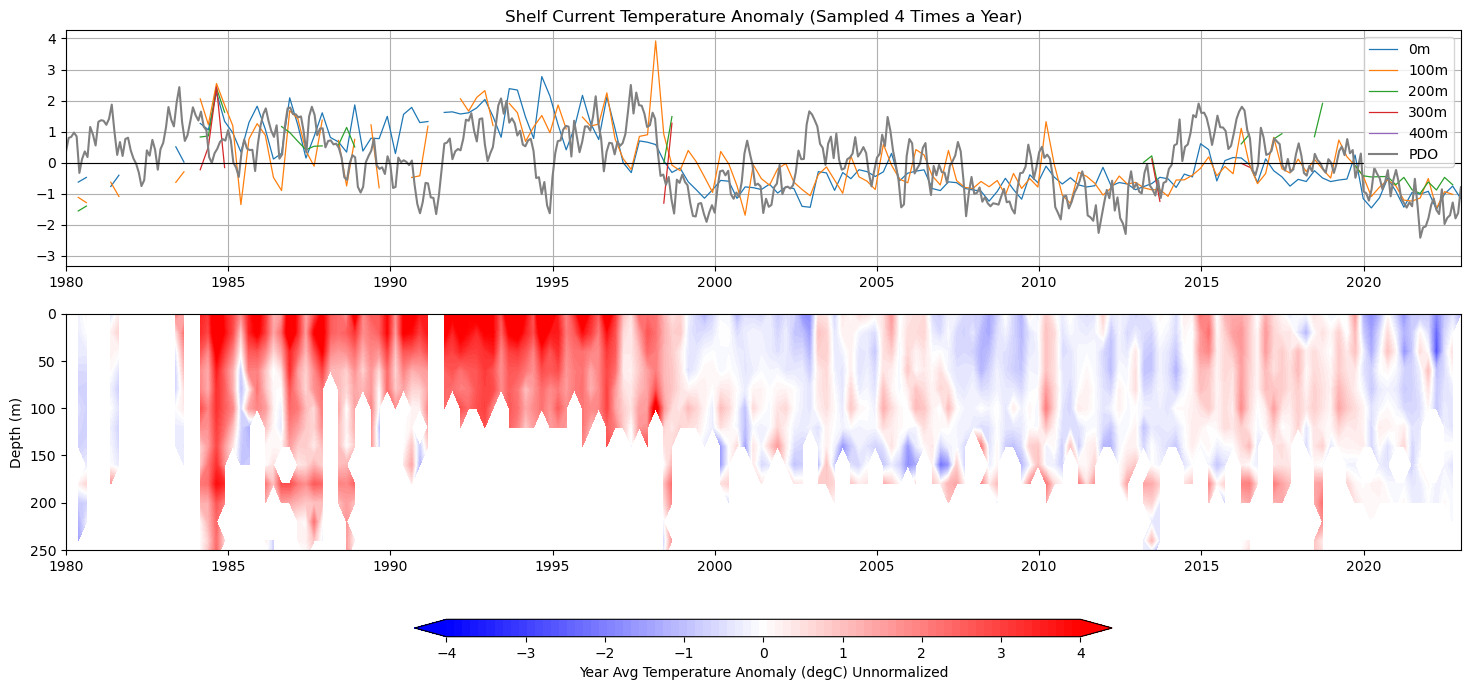

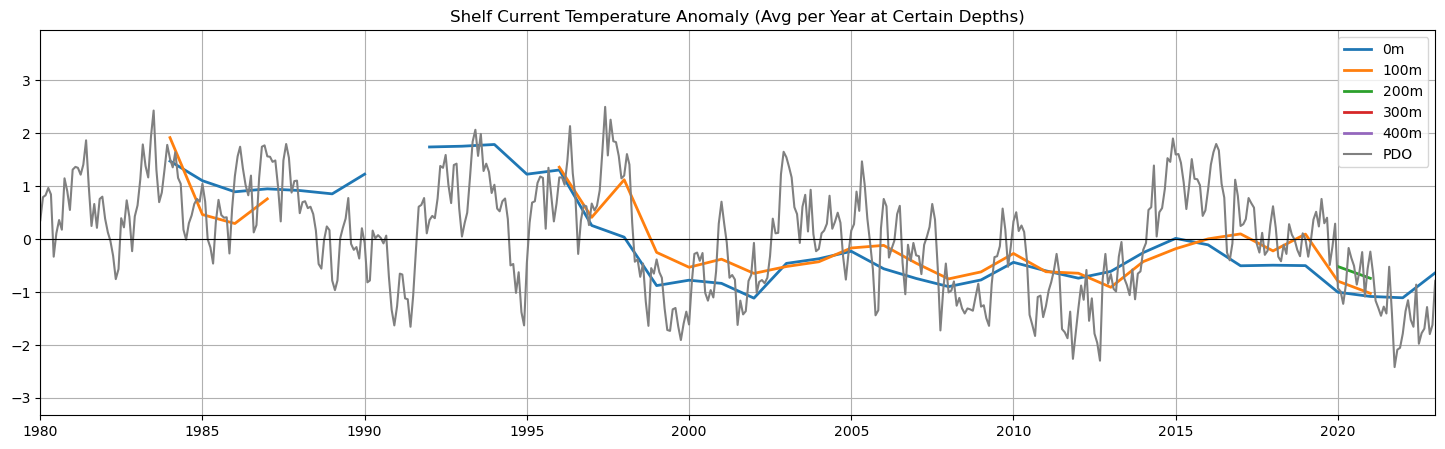

In [13]:
# Shelf Current temperature trends
obs_used = obs_shelf

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)


x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 5):
    dep_label = depth_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('Shelf Current Temperature Anomaly (Sampled 4 Times a Year)')

vmax=4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([0,250])
ax[1].invert_yaxis()

ticks = list(range(-vmax, vmax+1))
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

##############################################################################
fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 5):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('Shelf Current Temperature Anomaly (Avg per Year at Certain Depths)')


Text(0.5, 1.0, 'CC Temperature Anomaly (Avg per Year at Selected Depths)')

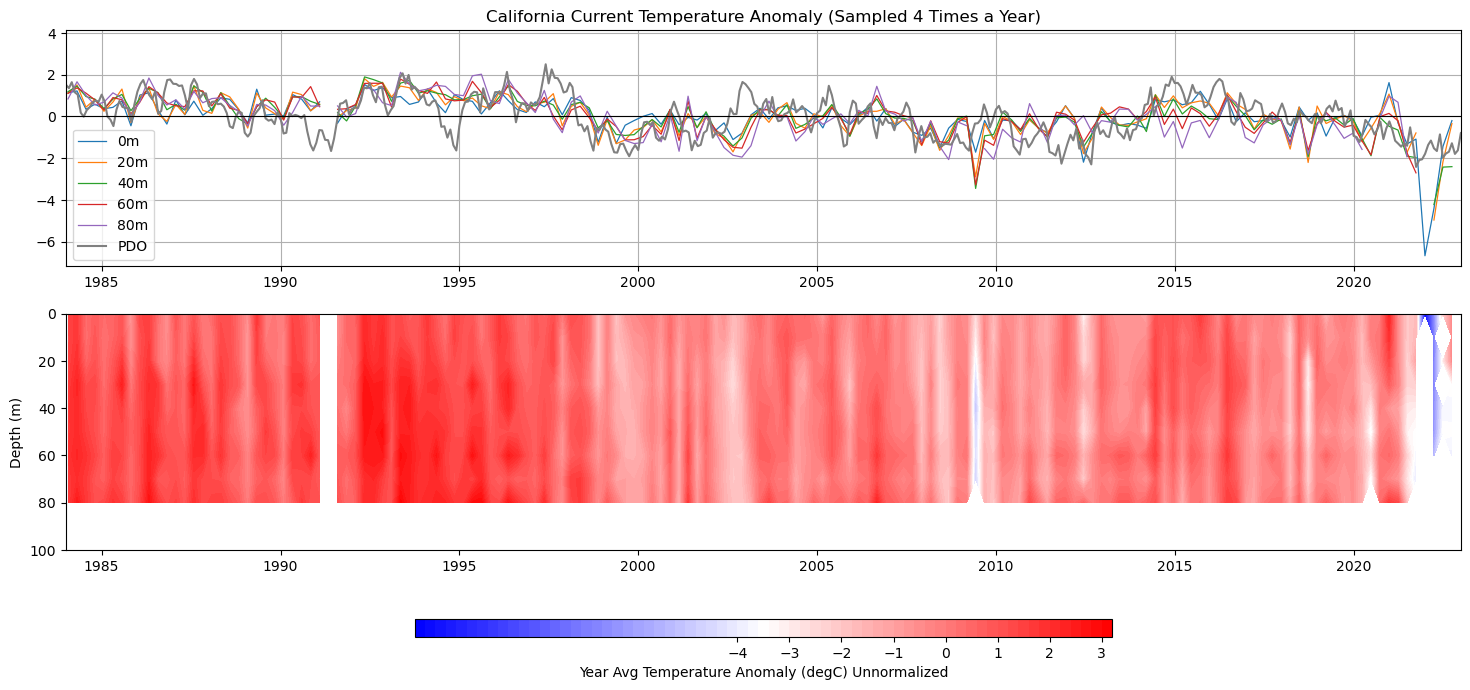

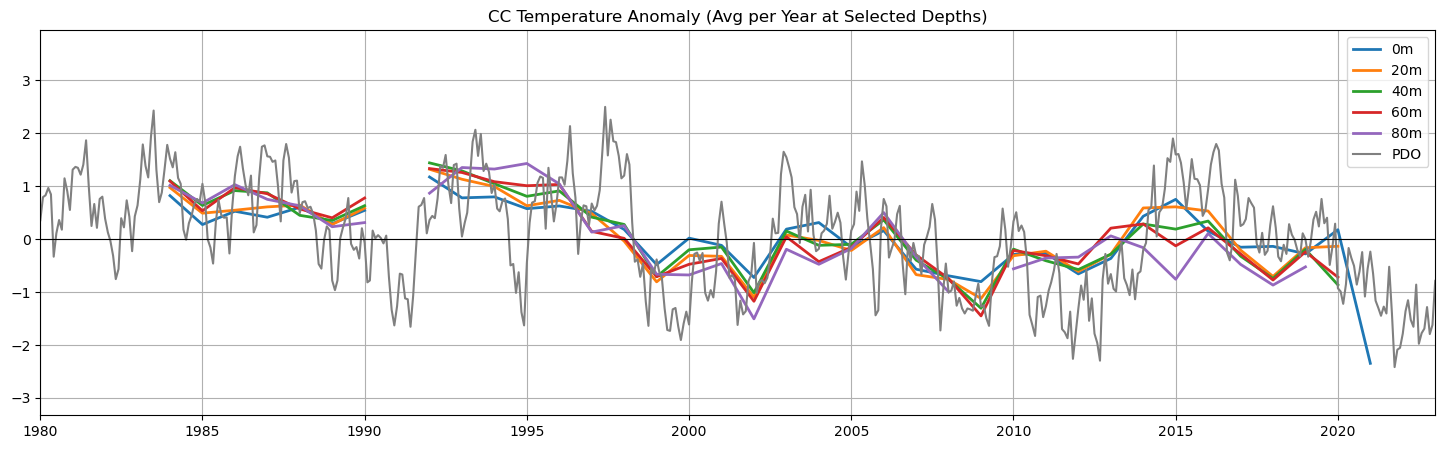

In [14]:
# California Current temperature depth trends
obs_used = obs_cc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,100,10) # Every 10m depth range
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 2):
    dep_label = depth_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1984,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Current Temperature Anomaly (Sampled 4 Times a Year)')

vmax=4
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1984,2023])
ax[1].set_ylim([0,100])
ax[1].invert_yaxis()

ticks = list(range(-vmax, vmax+1))
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 2):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('CC Temperature Anomaly (Avg per Year at Selected Depths)')

/tmp/ipykernel_364044/811006324.py:57: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)


Text(0.5, 1.0, 'California Undercurrent Temperature Anomaly (Avg per Year at Selected Depths)')

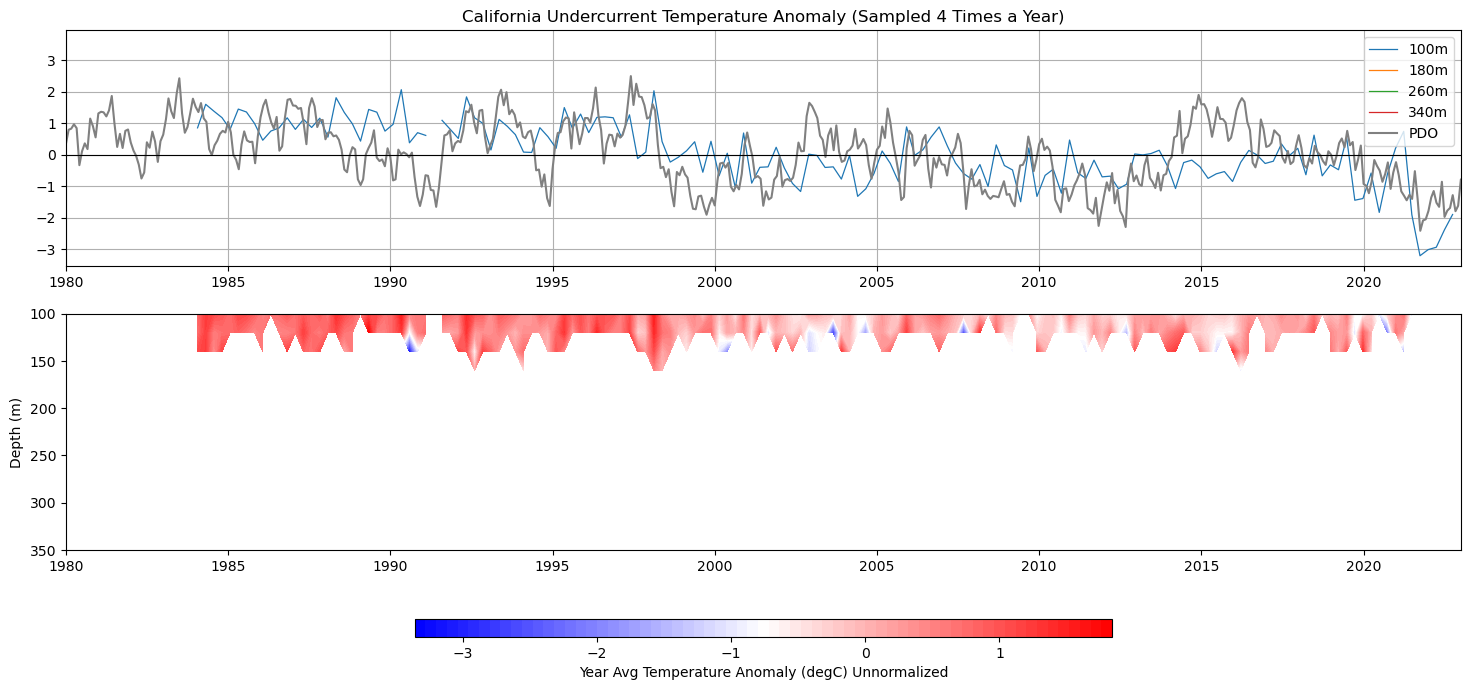

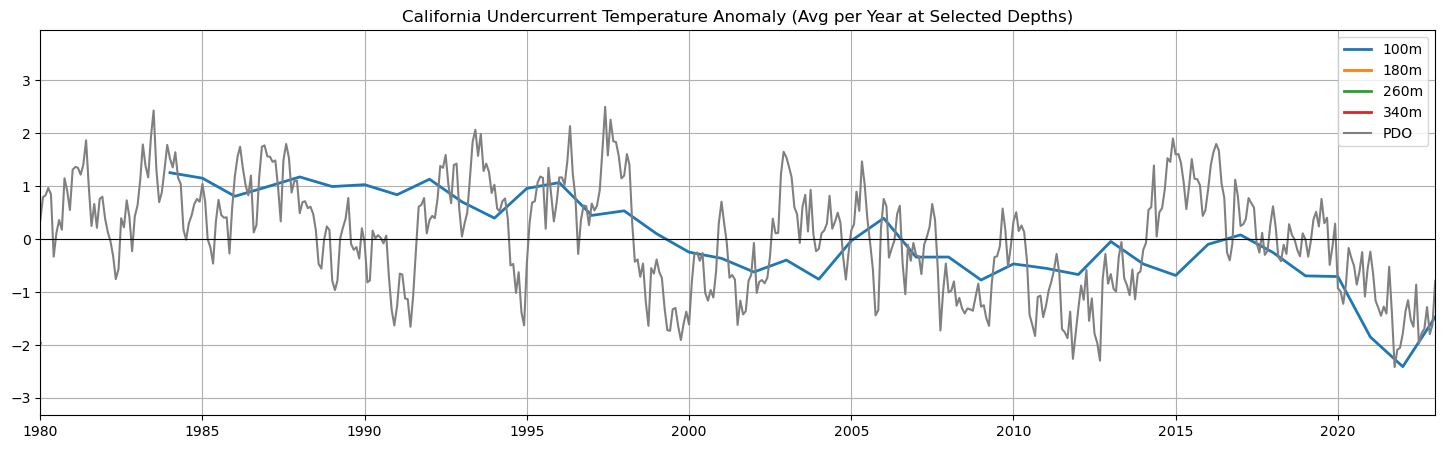

In [15]:
# California Undercurrent temperature depth trends
obs_used = obs_cuc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

dep_mask = ((depth_ranges >= 100) & (depth_ranges <= 350))
masked_depths = np.where(dep_mask)[0]  # indices of depths in range 100–350

for idx in masked_depths[::4]:  # every 5th depth index in range
    dep_label = depth_ranges[idx]
    ax[0].plot(x_yr_4times, zscore(anom_array[idx], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Undercurrent Temperature Anomaly (Sampled 4 Times a Year)')

vmax=3
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([100,350])
ax[1].invert_yaxis()

ticks = list(range(-vmax, vmax+1))
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)

for idx in masked_depths[::4]:  # every 5th depth index in range
    dep_label = depth_ranges[idx]
    averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)


# ax.plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax.plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('California Undercurrent Temperature Anomaly (Avg per Year at Selected Depths)')


## Salinity Depth Anomaly Plots

Text(0.5, 1.0, 'Shelf Current Salinity Anomaly (Avg per Year at Selected Depths)')

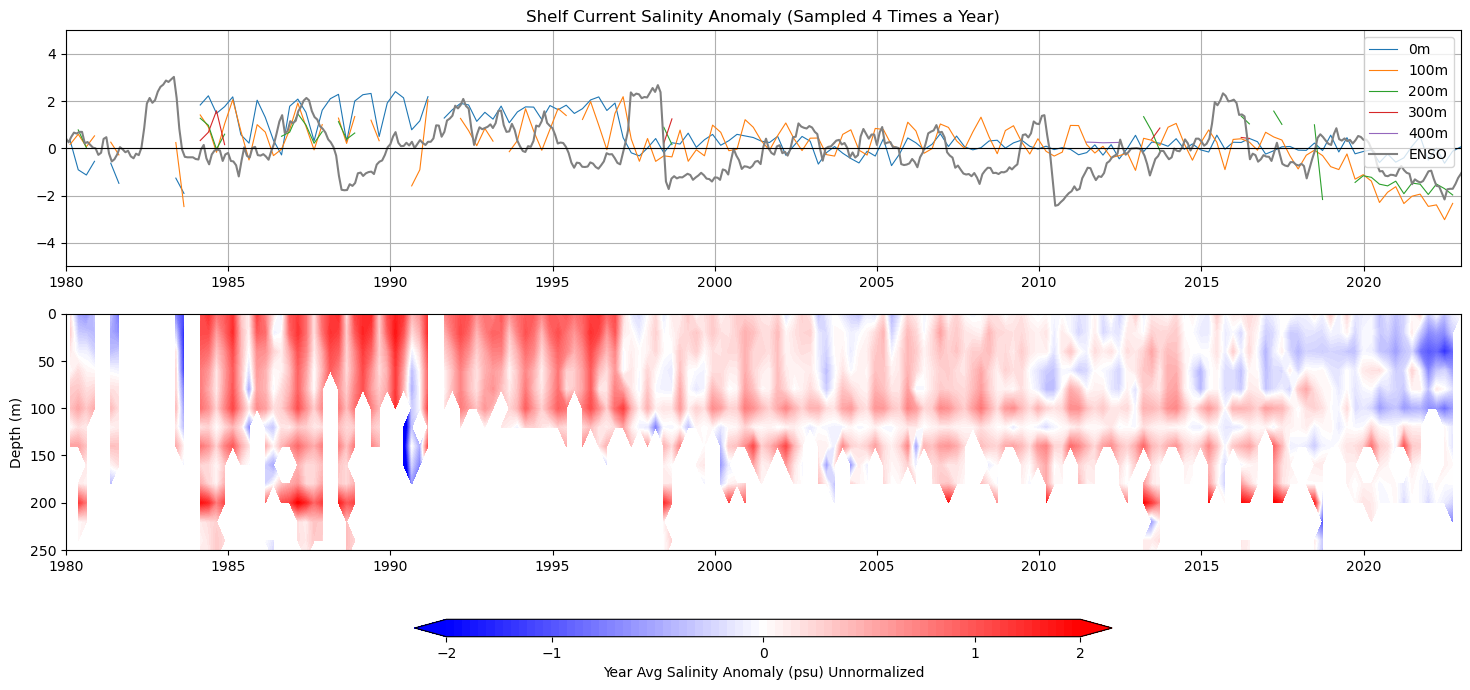

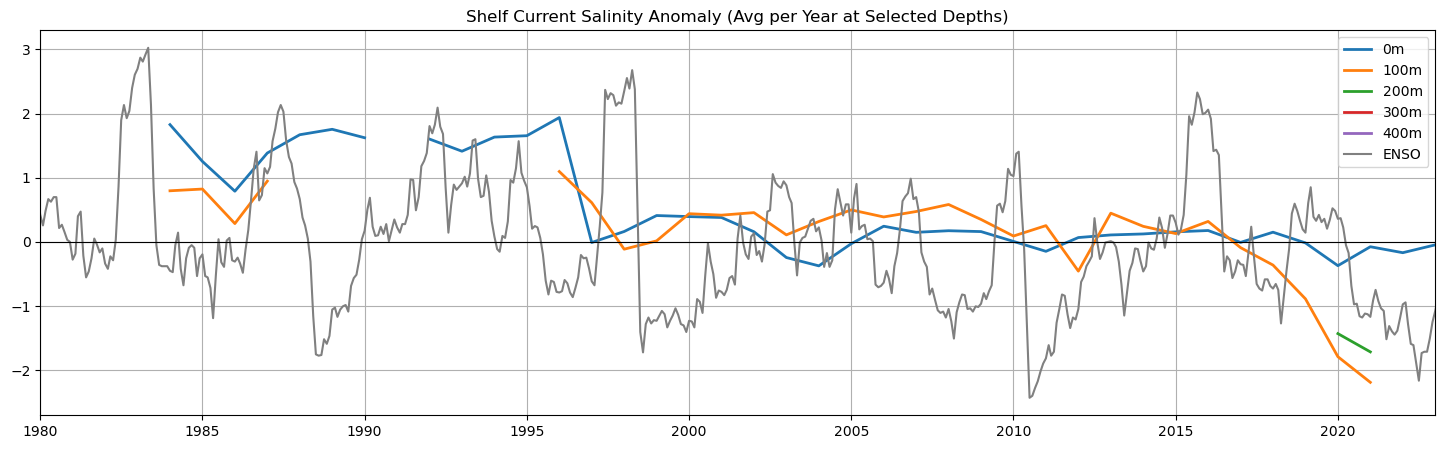

In [18]:
# Shelf Current salinity trends
obs_used = obs_shelf

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'salinity (g kg-1)' # Using salinity

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)


x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 5):
    dep_label = depth_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.8)

ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].set_ylim([-5,5])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('Shelf Current Salinity Anomaly (Sampled 4 Times a Year)')

vmax=1.5
levels = np.linspace(-vmax, vmax, 80)
cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([0,250])
ax[1].invert_yaxis()

ticks = list(range(-2, 2+1))
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Salinity Anomaly (psu) Unnormalized')

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 5):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

ax.plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('Shelf Current Salinity Anomaly (Avg per Year at Selected Depths)')


Text(0.5, 1.0, 'California Current Salinity Anomaly (Avg per Year at Selected Depths)')

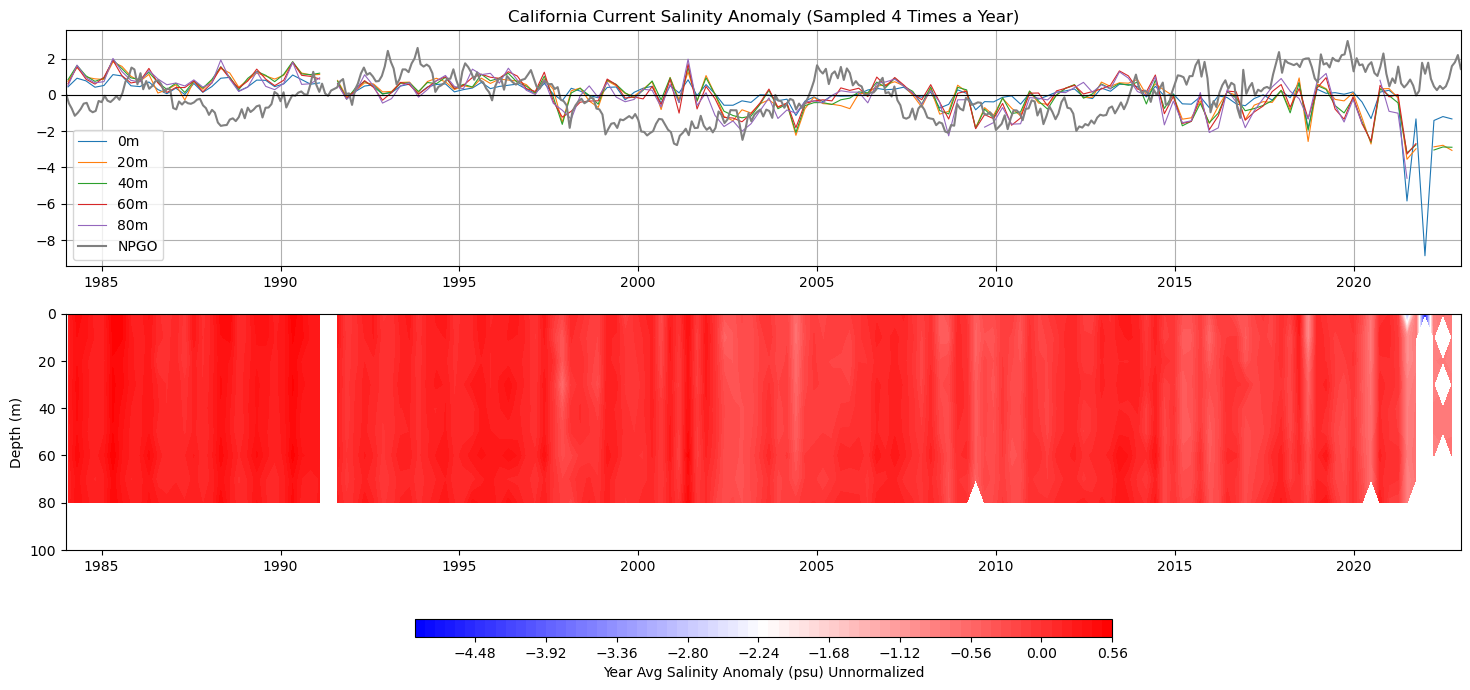

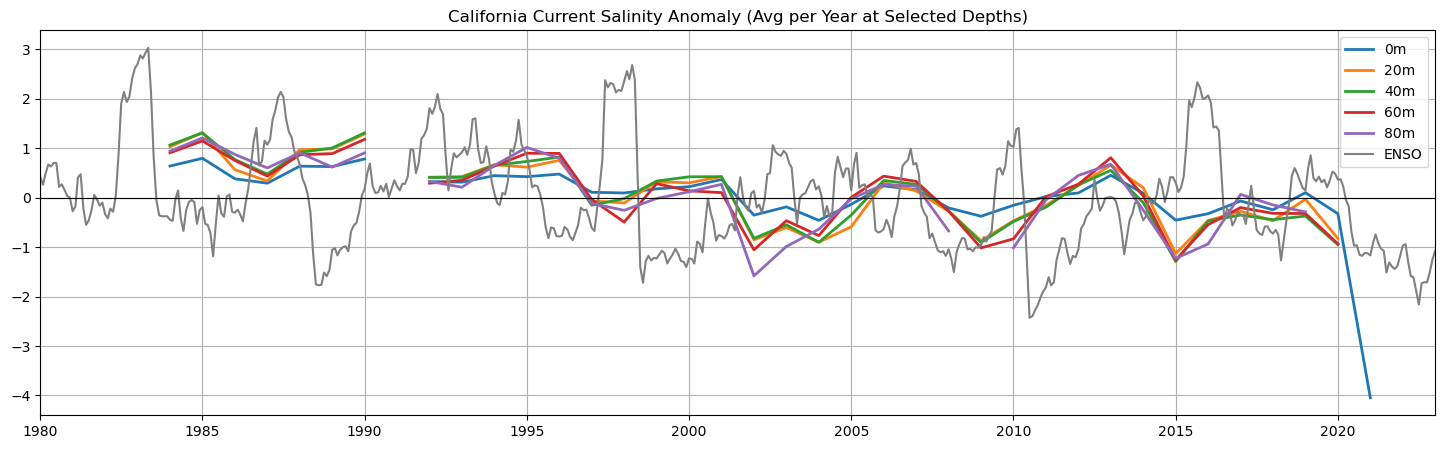

In [19]:
# California Current salinity trends
obs_used = obs_cc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,100,10) # Every 10m depth range
variable_str = 'salinity (g kg-1)' # Using salinity

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 2):
    dep_label = depth_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.8)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
ax[0].plot(npgo['decimal_yr'], -zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1984,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Current Salinity Anomaly (Sampled 4 Times a Year)')

vmax=3
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1984,2023])
ax[1].set_ylim([0,100])
ax[1].invert_yaxis()

# ticks = [-1, -0.5, 0, 0.5, 1, 1.5]
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5)#, ticks=ticks)
cbar.set_label('Year Avg Salinity Anomaly (psu) Unnormalized')

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 2):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

ax.plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('California Current Salinity Anomaly (Avg per Year at Selected Depths)')

/tmp/ipykernel_364044/1777688318.py:57: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)


Text(0.5, 1.0, 'California Undercurrent Salinity Anomaly (Avg per Year at Selected Depths)')

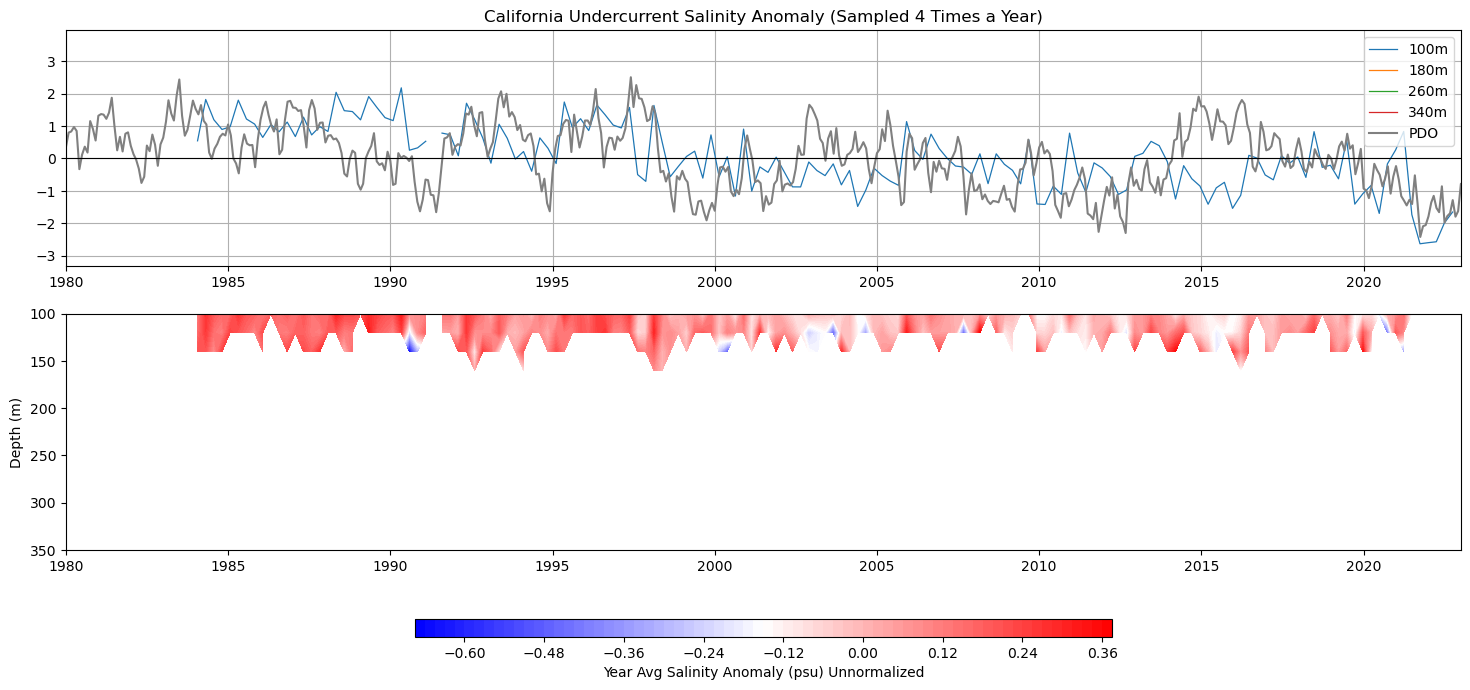

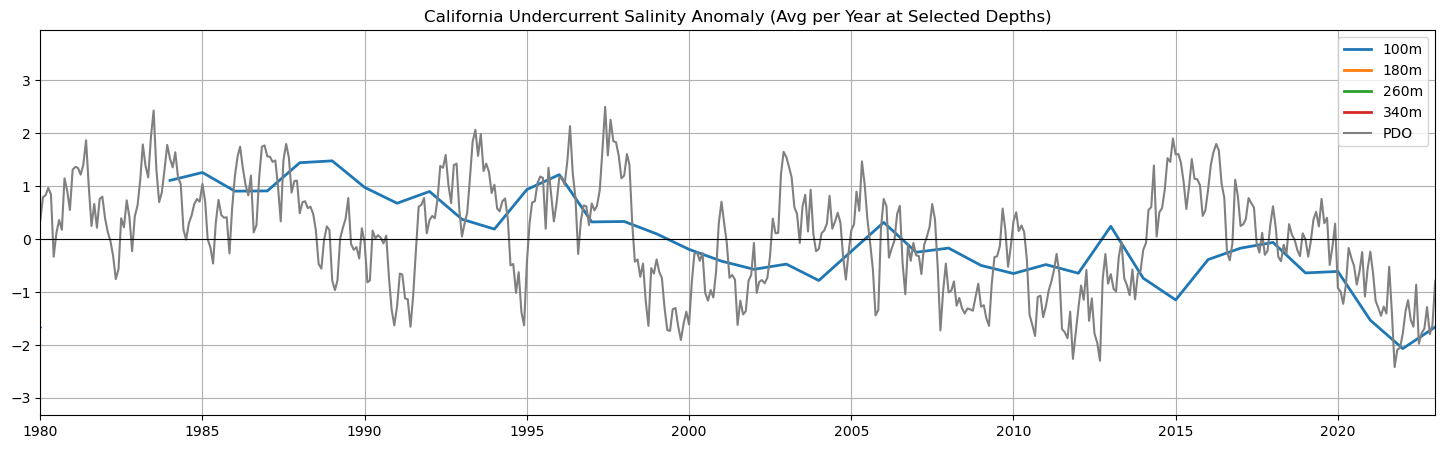

In [20]:
# California Undercurrent salinity trends
obs_used = obs_cuc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'salinity (g kg-1)' # Using salinity

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

dep_mask = ((depth_ranges >= 100) & (depth_ranges <= 350))
masked_depths = np.where(dep_mask)[0]  # indices of depths in range 100–350

for idx in masked_depths[::4]:  # every 5th depth index in range
    dep_label = depth_ranges[idx]
    ax[0].plot(x_yr_4times, zscore(anom_array[idx], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Undercurrent Salinity Anomaly (Sampled 4 Times a Year)')

vmax=3
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([100,350])
ax[1].invert_yaxis()

# ticks = [-1, -0.5, 0, 0.5, 1, 1.5]
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5)#, ticks=ticks)
cbar.set_label('Year Avg Salinity Anomaly (psu) Unnormalized')

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)

for idx in masked_depths[::4]:  # every 5th depth index in range
    dep_label = depth_ranges[idx]
    averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)


# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('California Undercurrent Salinity Anomaly (Avg per Year at Selected Depths)')

## Oxygen Anomaly Plots

/tmp/ipykernel_364044/440757331.py:26: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)


Text(0.5, 1.0, 'California Undercurrent DO Anomaly (Avg per Year at Selected Depths)')

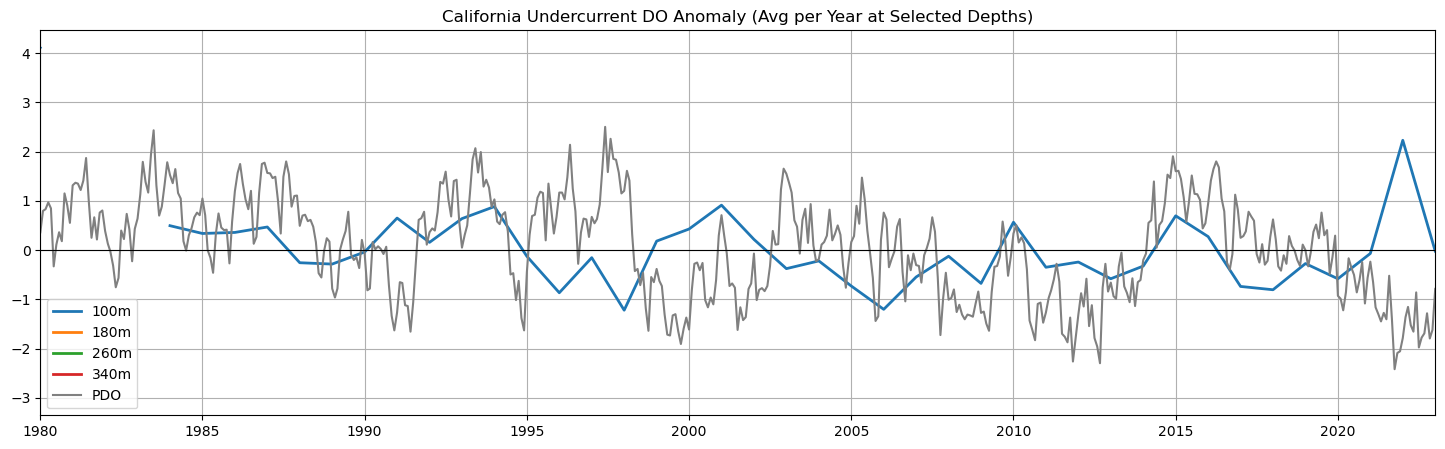

In [21]:
# California Undercurrent DO trends
obs_used = obs_cuc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'DO (umol kg-1)' # Using DO

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

dep_mask = ((depth_ranges >= 100) & (depth_ranges <= 350))
masked_depths = np.where(dep_mask)[0]  # indices of depths in range 100–350

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)

for idx in masked_depths[::4]:  # every 5th depth index in range
    dep_label = depth_ranges[idx]
    averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)


# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('California Undercurrent DO Anomaly (Avg per Year at Selected Depths)')

Text(0.5, 1.0, 'California Current DO Anomaly (Avg per Year at Selected Depths)')

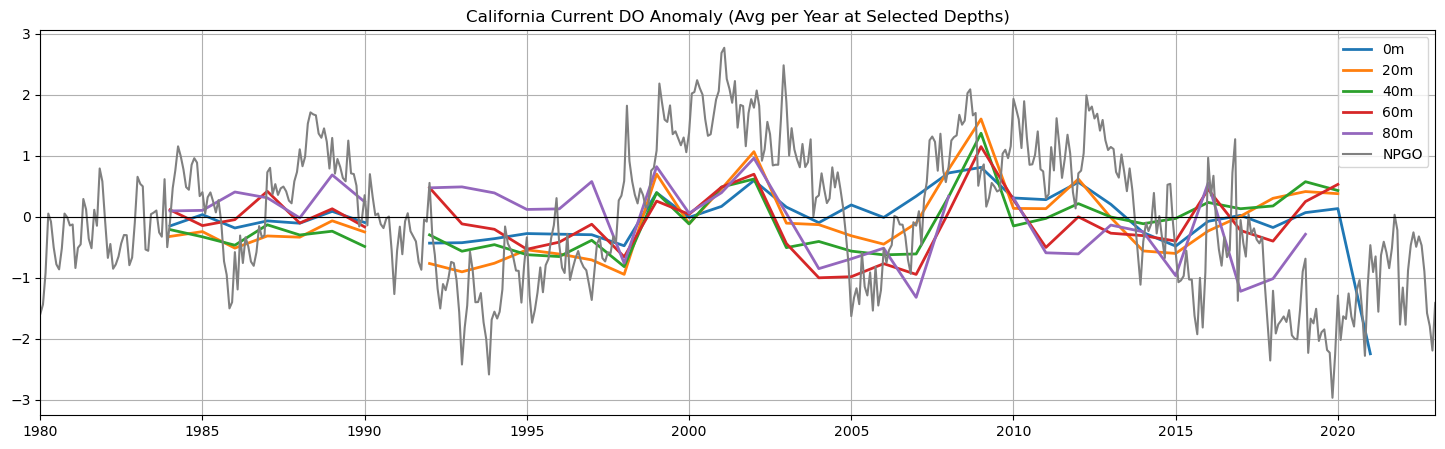

In [22]:
# California Current salinity trends
obs_used = obs_cc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,100,10) # Every 10m depth range
variable_str = 'DO (umol kg-1)' # Using DO

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 2):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

# ax.plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
ax.plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('California Current DO Anomaly (Avg per Year at Selected Depths)')

Text(0.5, 1.0, 'Shelf Current DO Anomaly (Avg per Year at Selected Depths)')

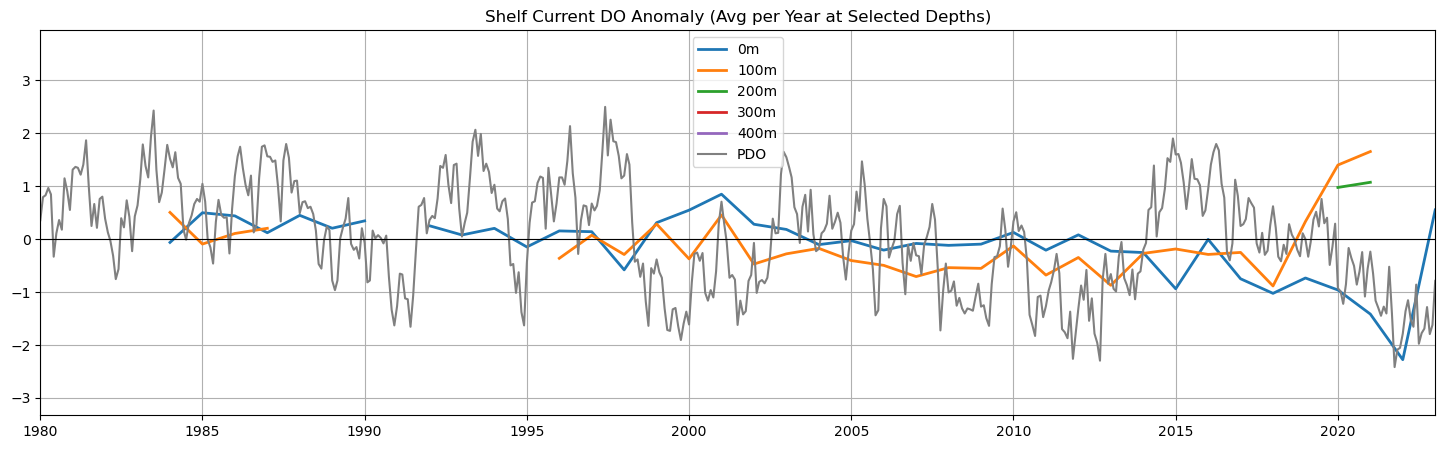

In [23]:
# Shelf Current DO trends
obs_used = obs_shelf

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'DO (umol kg-1)' # Using DO

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)


x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 5):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

# ax.plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax.plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('Shelf Current DO Anomaly (Avg per Year at Selected Depths)')

## Temperature Latitude Anomaly Plots

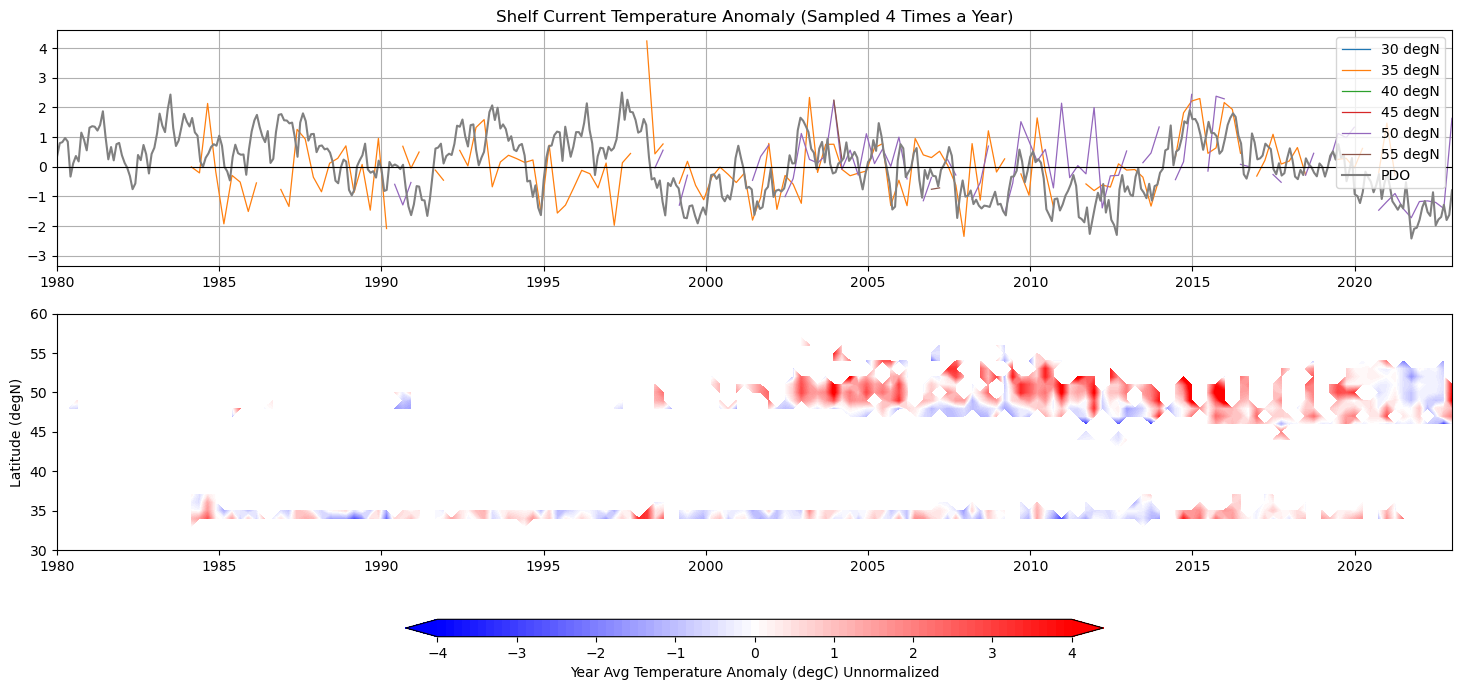

In [ ]:
# Shelf Current temperature latitude trends
obs_used = obs_shelf

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


lat_ranges = np.arange(30,60,1) # Every 1 degree north
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_lat(obs_used, start_yr, end_yr, lat_ranges, variable_str)


x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, lat_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 5):
    lat_label = lat_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{lat_label} degN', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('Shelf Current Temperature Anomaly (Sampled 4 Times a Year)')

vmax=4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

ax[1].set_ylabel('Latitude (degN)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([30,60])


ticks = list(range(-vmax, vmax+1))
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

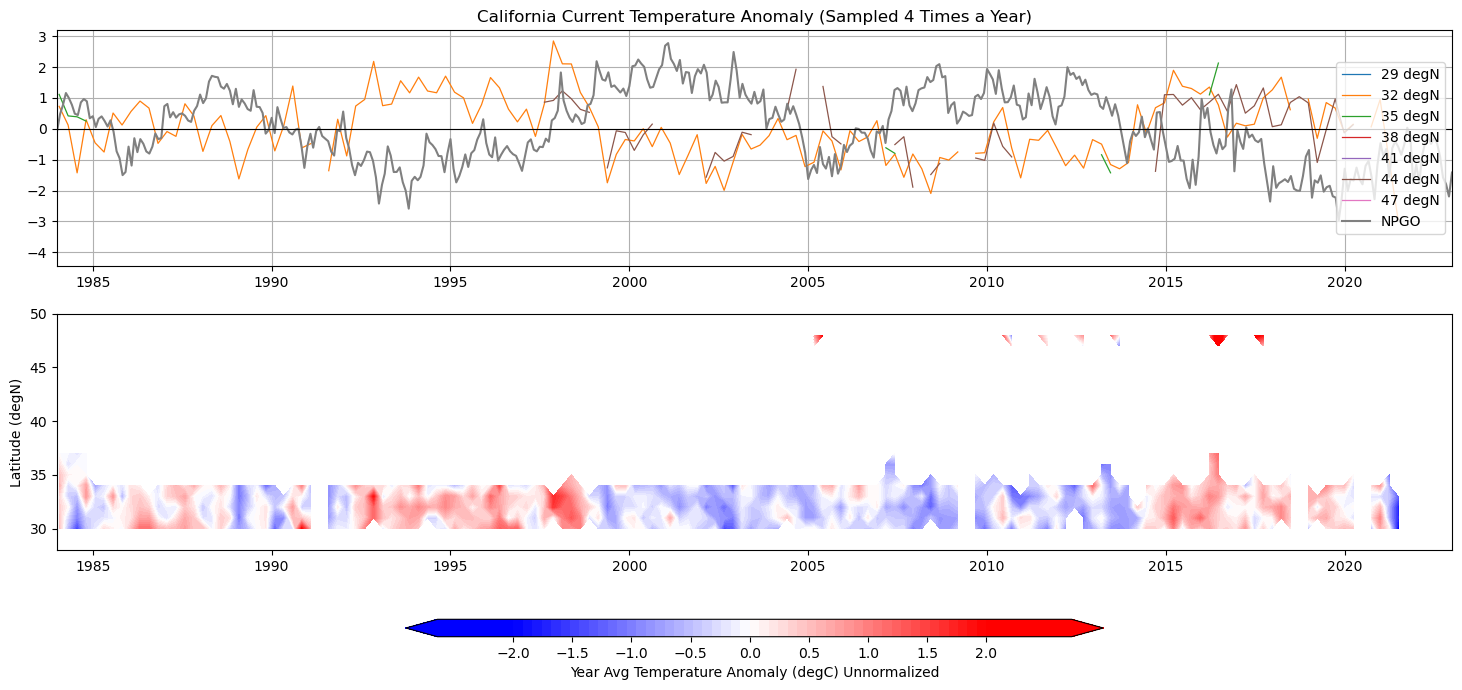

In [ ]:
# California Current temperature latitude trends
obs_used = obs_cc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


lat_ranges = np.arange(29,51,1) # Every degree N
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_lat(obs_used, start_yr, end_yr, lat_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, lat_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 3):
    lat_label = lat_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{lat_label} degN', linewidth=0.9)

# lat_mask = ((lat_ranges >= 100) & (lat_ranges <= 350))
# masked_lats = np.where(lat_mask)[0]  # indices of depths in range 100–350

# for idx in masked_lats[::4]:  # every 5th depth index in range
#     lat_label = lat_ranges[idx]
#     ax[0].plot(x_yr_4times, zscore(anom_array[idx], nan_policy='omit'), label=f'{lat_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1984,2023])
ax[0].legend(loc='right')
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Current Temperature Anomaly (Sampled 4 Times a Year)')

vmax=4
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr', vmin=-2, vmax=2, extend='both')

ax[1].set_ylabel('Latitude (degN)')
ax[1].set_xlim([1984,2023])
ax[1].set_ylim([28,50])

ticks = [x/2 for x in range(-vmax, vmax+1)]
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

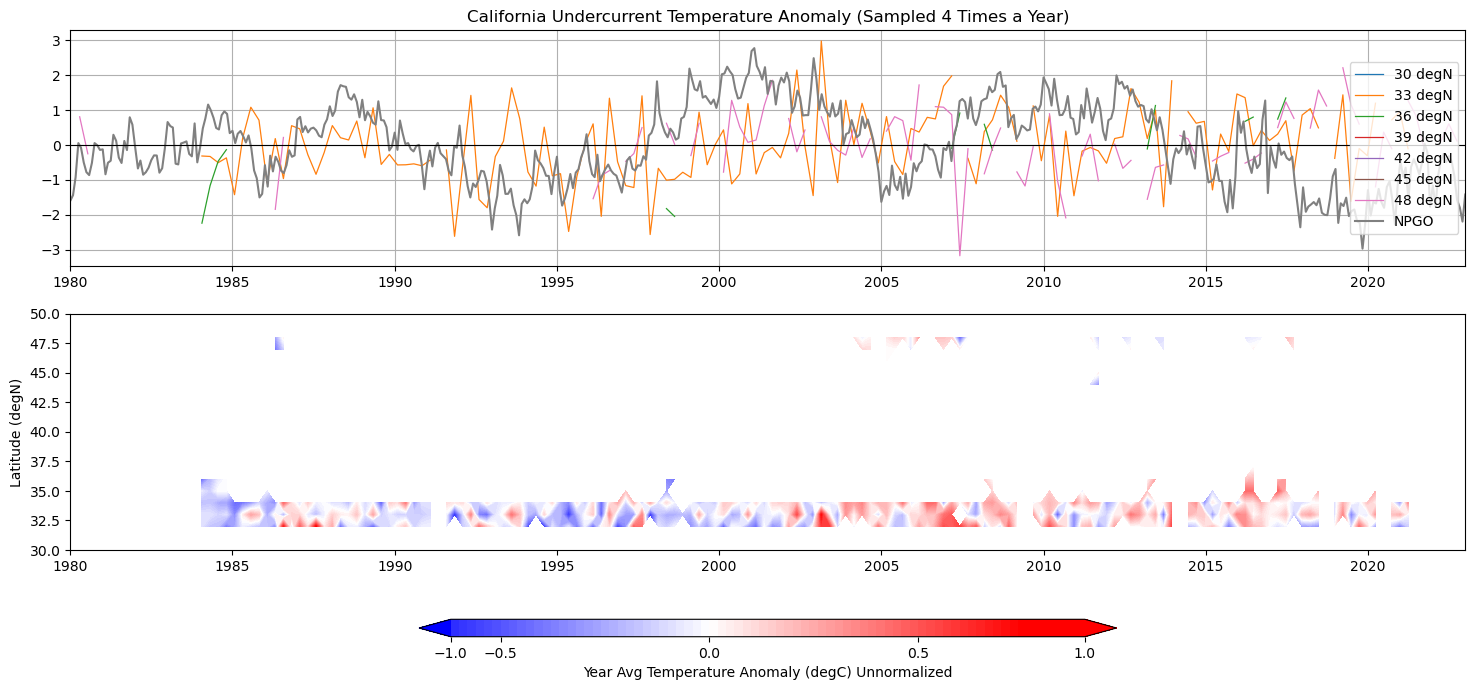

In [ ]:
# California Undercurrent temperature latitude trends
obs_used = obs_cuc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


lat_ranges = np.arange(30,50,1) # Every degree N
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_lat(obs_used, start_yr, end_yr, lat_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, lat_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 3):
    lat_label = lat_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{lat_label} degN', linewidth=0.9)

# lat_mask = ((lat_ranges >= 100) & (lat_ranges <= 350))
# masked_lats = np.where(lat_mask)[0]  # indices of depths in range 100–350

# for idx in masked_lats[::4]:  # every 5th depth index in range
#     lat_label = lat_ranges[idx]
#     ax[0].plot(x_yr_4times, zscore(anom_array[idx], nan_policy='omit'), label=f'{lat_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].legend(loc='right')
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Undercurrent Temperature Anomaly (Sampled 4 Times a Year)')

vmax=2
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr', vmin=-0.75,vmax=0.75, extend='both')

ax[1].set_ylabel('Latitude (degN)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([30,50])

ticks = [x/2 for x in range(-vmax, vmax+1)]
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')